To create the CNN classification model using Tensorflow (Can be generated using both CPU and GPU)

Based on https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

Step 1) Functions for creating spectrograms and PNGs from WAV files

In [3]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr, S=None, n_fft=1024, hop_length=80, win_length=320, window='hann', center=True, pad_mode='constant', power=2.0) # Wideband spectrogram
    #ms = librosa.feature.melspectrogram(y=y, sr=sr, S=None) # Narrow band spectrogram
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

Step 2) Converting all the wav files into its spectrogram representation (saving images as x and SNR labels as y)

In [11]:
# Destination of the dataset
path_dataset = "../../Dataset/dataset/"
path_clean = path_dataset + "/clean/"
path_0dB = path_dataset + "/0dB/"
path_n3dB = path_dataset + "/-3dB/"
path_n6dB = path_dataset + "/-6dB/"
path_n9dB = path_dataset + "/-9dB/"
path_3dB = path_dataset + "/3dB/"
path_6dB = path_dataset + "/6dB/"
path_9dB = path_dataset + "/9dB/"

In [12]:
# Spectrogram destination
path_spectrogram = "Spectrograms/training_spectrogram/"
spath_clean = path_spectrogram + "/clean/"
spath_0dB = path_spectrogram + "/0dB/"
spath_n3dB = path_spectrogram + "/-3dB/"
spath_n6dB = path_spectrogram + "/-6dB/"
spath_n9dB = path_spectrogram + "/-9dB/"
spath_3dB = path_spectrogram + "/3dB/"
spath_6dB = path_spectrogram + "/6dB/"
spath_9dB = path_spectrogram + "/9dB/"

In [6]:
# Create the spectrograms destination
isExist = os.path.exists(path_spectrogram)
if not isExist:
       # Create a new directory because it does not exist
   os.makedirs(path_spectrogram)
   os.makedirs(path_spectrogram + "/clean")
   os.makedirs(path_spectrogram + "/0dB")
   os.makedirs(path_spectrogram + "/-3dB")
   os.makedirs(path_spectrogram + "/-6dB")
   os.makedirs(path_spectrogram + "/-9dB")
   os.makedirs(path_spectrogram + "/3dB")
   os.makedirs(path_spectrogram + "/6dB")
   os.makedirs(path_spectrogram + "/9dB")
   print("the %s directory is created!", path_spectrogram)

the %s directory is created! Spectrograms


In [13]:
# creating spectrograms
create_pngs_from_wavs(path_clean, spath_clean)
create_pngs_from_wavs(path_0dB, spath_0dB)
create_pngs_from_wavs(path_n3dB, spath_n3dB)
create_pngs_from_wavs(path_n6dB, spath_n6dB)
create_pngs_from_wavs(path_n9dB, spath_n9dB)
create_pngs_from_wavs(path_3dB, spath_3dB)
create_pngs_from_wavs(path_6dB, spath_6dB)
create_pngs_from_wavs(path_9dB, spath_9dB)

In [14]:
# Load images
def load_images_from_path(path, label, limit=1500):
    images = []
    labels = []

    file_list = os.listdir(path)
    if limit is not None:
        file_list = file_list[:limit]

    for file in file_list:
        images.append(img_to_array(load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append(label)
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

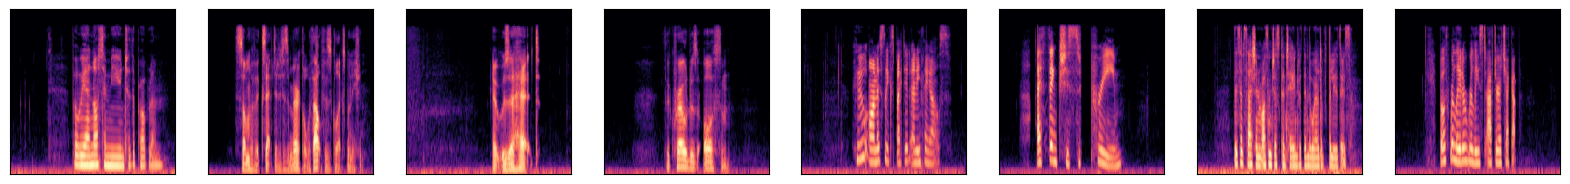

In [15]:
images, labels = load_images_from_path(spath_clean, 0)
show_images(images)
    
x += images
y += labels

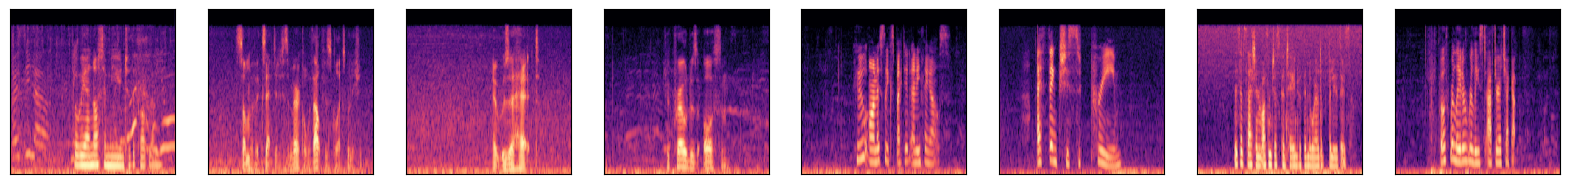

In [16]:
images, labels = load_images_from_path(spath_9dB, 1)
show_images(images)
    
x += images
y += labels

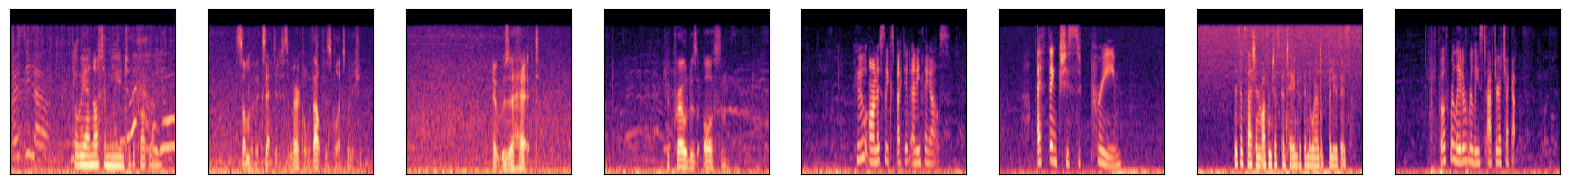

In [17]:
images, labels = load_images_from_path(spath_6dB, 2)
show_images(images)
    
x += images
y += labels

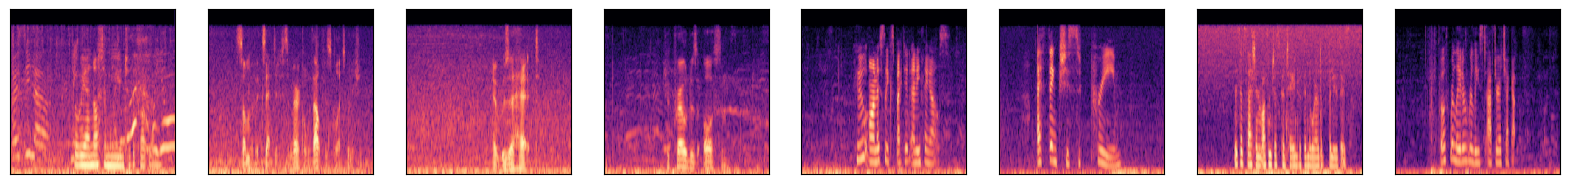

In [18]:
images, labels = load_images_from_path(spath_3dB, 3)
show_images(images)
    
x += images
y += labels

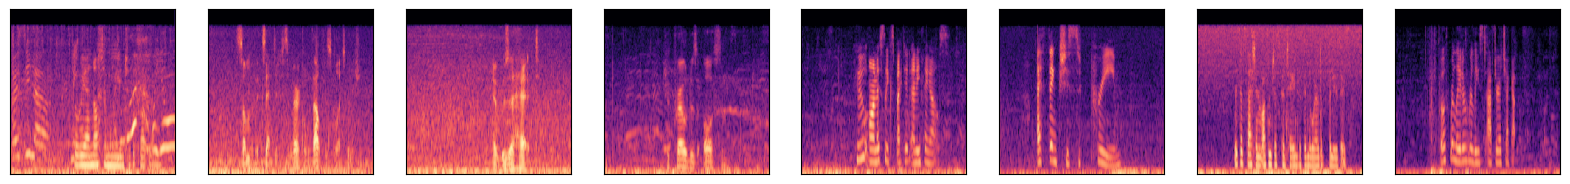

In [19]:
images, labels = load_images_from_path(spath_0dB, 4)
show_images(images)
    
x += images
y += labels

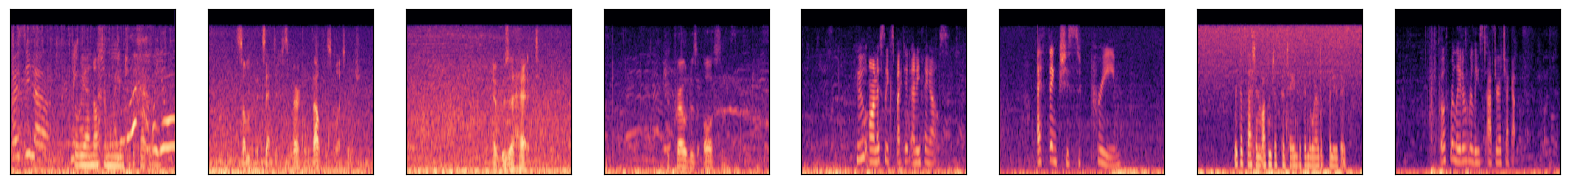

In [20]:
images, labels = load_images_from_path(spath_n3dB, 5)
show_images(images)
    
x += images
y += labels

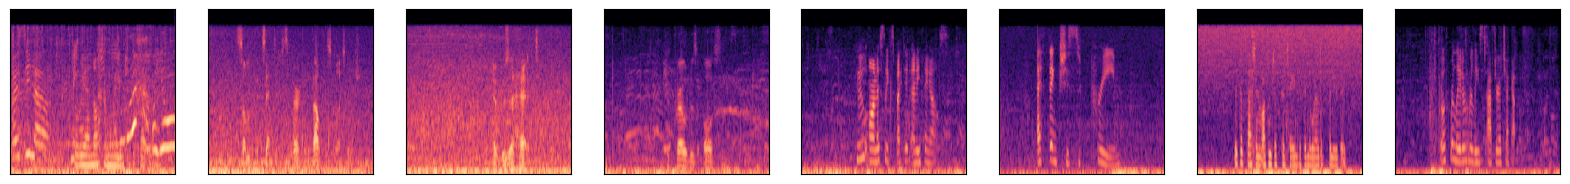

In [21]:
images, labels = load_images_from_path(spath_n6dB, 6)
show_images(images)
    
x += images
y += labels

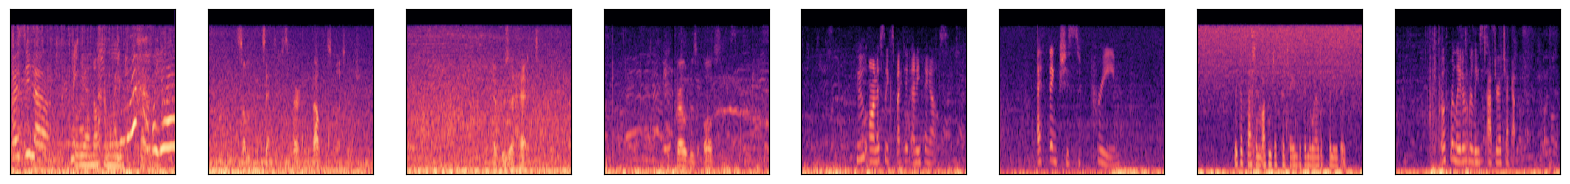

In [22]:
images, labels = load_images_from_path(spath_n9dB, 7)
show_images(images)
    
x += images
y += labels

Step 3) Spliting the dataset into training and testing 80/20, respectively 

In [24]:
# Split the data into training, validation, and testing sets can change the test_size and random_state
x_train, x_temp, y_train, y_temp = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0) # 80% training and 20% testing and validation
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=0) # 50% validation and 50% testing of the 20% of the data

# Normalize the data
x_train_norm = np.array(x_train) / 255
x_val_norm = np.array(x_val) / 255
x_test_norm = np.array(x_test) / 255

# Encode the labels
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(8, activation='softmax')) # 8 predicted classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Step 4) Training the model with a batch size of 10 and epoch number of 20

In [26]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_val_norm, y_val_encoded), batch_size=10, epochs=20) # Epoch and batch size can be changed

Epoch 1/20
64/64 [==============================] - 7s 19ms/step - loss: 1.9666 - accuracy: 0.1969 - val_loss: 1.9203 - val_accuracy: 0.2125
Epoch 2/20
64/64 [==============================] - 1s 17ms/step - loss: 1.8232 - accuracy: 0.2344 - val_loss: 1.8823 - val_accuracy: 0.2000
Epoch 3/20
64/64 [==============================] - 1s 17ms/step - loss: 1.7668 - accuracy: 0.2297 - val_loss: 1.8032 - val_accuracy: 0.2250
Epoch 4/20
64/64 [==============================] - 1s 17ms/step - loss: 1.7758 - accuracy: 0.2234 - val_loss: 1.8570 - val_accuracy: 0.2375
Epoch 5/20
64/64 [==============================] - 1s 17ms/step - loss: 1.7368 - accuracy: 0.2547 - val_loss: 1.8866 - val_accuracy: 0.2250
Epoch 6/20
64/64 [==============================] - 1s 17ms/step - loss: 1.7103 - accuracy: 0.2609 - val_loss: 1.9421 - val_accuracy: 0.1500
Epoch 7/20
64/64 [==============================] - 1s 17ms/step - loss: 1.6993 - accuracy: 0.2734 - val_loss: 1.8714 - val_accuracy: 0.2375
Epoch 8/20
64

Step 5) Evaluation

[]

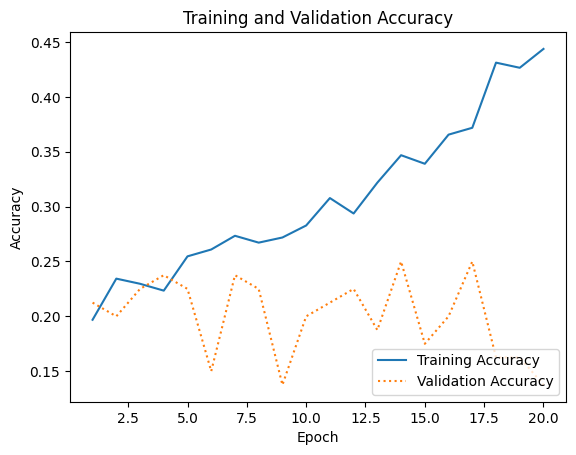

In [31]:
# Graph of accuracy and loss over each epoch for the training and validation sets
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [32]:
# Test the model on the testing set
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


3/3 [==============================] - 1s 64ms/step - loss: 1.8482 - accuracy: 0.2500
Test Loss: 1.8481826782226562
Test Accuracy: 0.25


Text(110.44999999999997, 0.5, 'Actual label')

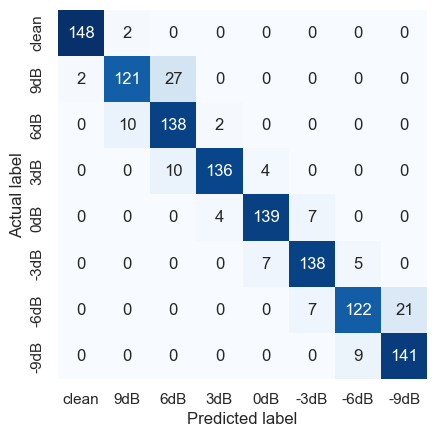

In [18]:
# A confusion matrix to visualize the performance of the model
sns.set()
y_predicted = model.predict(x_test_norm)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['clean', '9dB', '6dB', '3dB', '0dB', '-3dB', '-6dB', '-9dB']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Step 6) Saving the model

In [34]:
model_path = "../../Models/Classification-Models/" # Destination of the model

isExist = os.path.exists(model_path)
if not isExist:
    # Create a new directory because it does not exist
   os.makedirs(model_path)
   print("the %s directory is created!", model_path)

In [36]:
model.save(model_path + 'cnn_model.h5') # Save the model can change the name of the model

Step 7) Loading the model

In [38]:
model_path = "../../Models/Classification-Models/" # Destination of the model
# Recreate the exact same model, including its weights and the optimizer
load_model = tf.keras.models.load_model(model_path + 'cnn_model.h5')

# Show the model architecture
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Step 8) Using loaded model to predict all audio SNR levels from a folder

- The audio file needs to be in the format of a wav file
- The name of the audio must be called speech_"number".wav the same as the create_dataset convention (With the text inside "" being changed to a number)

In [47]:
# Directory of the audio wanted to be predicted
path_test_dataset = "../../Dataset/predict_dataset/"

In [48]:
entries = os.listdir(path_test_dataset)
print("Amount of files to predict: " + str(len(entries)))

Amount of files to predict: 50


In [85]:
# Creating the spectrograms of the prediction dataset
path_spec_predit = "Spectrograms/predicted_spectrograms"
# Create the saving prediction destination
path_prediction = "Predictions/"

isExist = os.path.exists(path_spec_predit)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path_spec_predit)
    print("the %s directory is created!", path_spec_predit)

isExist = os.path.exists(path_prediction)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path_prediction)
    print("the %s directory is created!", path_prediction)

the %s directory is created! Predictions/


In [50]:
# Creating the spectrograms of the prediction dataset
create_pngs_from_wavs(path_test_dataset, path_spec_predit)

In [70]:
# Function to extract the numerical part from a filename
def extract_number_from_filename(filename):
    try:
        # Split the filename at the underscore and extract the last part
        number_str = filename.split('_')[-1].split('.')[0]
        # Convert it to an integer and return
        return int(number_str)
    except ValueError:
        # If there's no valid number in the filename, return 0
        return 0

In [88]:
target_names = ["clean", "0dB", "-3dB", "-6dB", "-9dB", "3dB", "6dB", "9dB"]
image_paths = os.listdir(path_spec_predit)
# Sort image_paths based on the numerical part of their names
image_paths.sort(key=extract_number_from_filename)

for image_path in image_paths:
    # Preprocess the image
    image = img_to_array(load_img((path_spec_predit + "/" + image_path), target_size=(224, 224, 3)))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    # Make a prediction
    predictions = load_model.predict(image)
    
    # Show the prediction
    score = tf.nn.softmax(predictions[0])
    print(
        image_path.split(".")[0] + " is most likely belongs to {} with a {:.2f} percent confidence."
        .format(target_names[np.argmax(score)], 100 * np.max(score))
    )
    # Saving prediction
    file = open(path_prediction + "/predictions1.txt", "a") # Destination of the prediction file
    file.write(image_path.split(".")[0] + " is most likely belongs to {} with a {:.2f} percent confidence.\n"
        .format(target_names[np.argmax(score)], 100 * np.max(score)))
    file.close()

speech_1 is most likely belongs to 9dB with a 13.87 percent confidence.
speech_2 is most likely belongs to -9dB with a 13.29 percent confidence.
speech_3 is most likely belongs to 0dB with a 23.18 percent confidence.
speech_4 is most likely belongs to 3dB with a 13.29 percent confidence.
speech_5 is most likely belongs to 0dB with a 14.19 percent confidence.
speech_6 is most likely belongs to 9dB with a 18.16 percent confidence.
speech_7 is most likely belongs to 0dB with a 19.43 percent confidence.
speech_8 is most likely belongs to 3dB with a 13.39 percent confidence.
speech_9 is most likely belongs to 9dB with a 16.78 percent confidence.
speech_10 is most likely belongs to 9dB with a 13.50 percent confidence.
speech_11 is most likely belongs to 9dB with a 13.80 percent confidence.
speech_12 is most likely belongs to 0dB with a 20.31 percent confidence.
speech_13 is most likely belongs to 9dB with a 13.51 percent confidence.
speech_14 is most likely belongs to -6dB with a 13.05 perce